In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from utils import (
    NAN_THRESHOLD,
    AdjacencyMethod,
    GraphEvent,
    load_events,
)

In [5]:
events = load_events()

## Preprocess DataFrames

Somes events have 2-min resolution (we download them for 1-min though), so we decided to standardize all events to 2-min. And, apparently, the data cannot have any NaN value

In [ ]:
def invalid_stations(station_df: pd.DataFrame, use_threshold: bool) -> List[str]:
    """Check if a station has less than NAN_THRESHOLD percentage of NaN values."""
    nan_ratios = station_df.isna().mean()

    if use_threshold:
        invalid_stations = nan_ratios[nan_ratios >= NAN_THRESHOLD].index.tolist()
    else:
        invalid_stations = nan_ratios[nan_ratios > 0].index.tolist()

    return invalid_stations

In [7]:
# Fill data preprocessing
for event_name, data in events.items():
    df = data["raw"]

    # Drop stations with too many NaNs
    stations_to_drop = invalid_stations(df, use_threshold=False)
    df = df.drop(columns=stations_to_drop)

    # Resample to 2-minute intervals using median
    events[event_name]["raw"] = df.resample("2min").median()

## Create graphs

In [8]:
for event_date, data in events.items():
    for method in AdjacencyMethod:
        df = data["raw"].reset_index(drop=True)
        graph_event = GraphEvent(
            data=df,
            metadata={
                "event_date": event_date,
                "intensity": data["intensity"],
                "cutoff_rigidity": data["cutoff_rigidity"],
            },
        )

        events[event_date]["graphs"][method] = graph_event.get_graph_networkx(method)

## Draw graphs

In [9]:
for event_date, data in events.items():
    print(f"Event: {event_date}")
    for method, graph in data["graphs"].items():
        print(
            f"  Method: {method.name}, Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}"
        )

Event: 2023-04-23
  Method: CORRELATION, Nodes: 27, Edges: 351
  Method: COSINE, Nodes: 27, Edges: 351
  Method: MANHATTAN, Nodes: 27, Edges: 351
  Method: MINKOWSKI, Nodes: 27, Edges: 351
Event: 2024-03-24
  Method: CORRELATION, Nodes: 27, Edges: 351
  Method: COSINE, Nodes: 27, Edges: 351
  Method: MANHATTAN, Nodes: 27, Edges: 351
  Method: MINKOWSKI, Nodes: 27, Edges: 351
Event: 2024-05-10
  Method: CORRELATION, Nodes: 25, Edges: 300
  Method: COSINE, Nodes: 25, Edges: 300
  Method: MANHATTAN, Nodes: 25, Edges: 300
  Method: MINKOWSKI, Nodes: 25, Edges: 300


In [10]:
events["2023-04-23"]["cutoff_rigidity"]

{'AATB': 5.9,
 'APTY': 0.65,
 'ATHN': 8.53,
 'BKSN': 5.7,
 'CALG': 1.08,
 'CALM': 6.95,
 'DOMB': 0.01,
 'DOMC': 0.01,
 'DRBS': 3.18,
 'FSMT': 0.3,
 'INVK': 0.3,
 'IRK2': 3.64,
 'IRK3': 3.64,
 'IRKT': 3.64,
 'JBGO': 0.3,
 'JUNG': 4.49,
 'JUNG1': 4.49,
 'KERG': 1.14,
 'KIEL2': 2.36,
 'LMKS': 3.84,
 'MWSN': 0.22,
 'MXCO': 8.28,
 'NAIN': 0.3,
 'NANM': 7.1,
 'NEWK': 2.4,
 'NRLK': 0.63,
 'OULU': 0.81,
 'PWNK': 0.3,
 'ROME': 6.27,
 'SOPB': 0.1,
 'SOPO': 0.1,
 'TERA': 0.01,
 'THUL': 0.3,
 'TXBY': 0.48,
 'YKTK': 1.65}

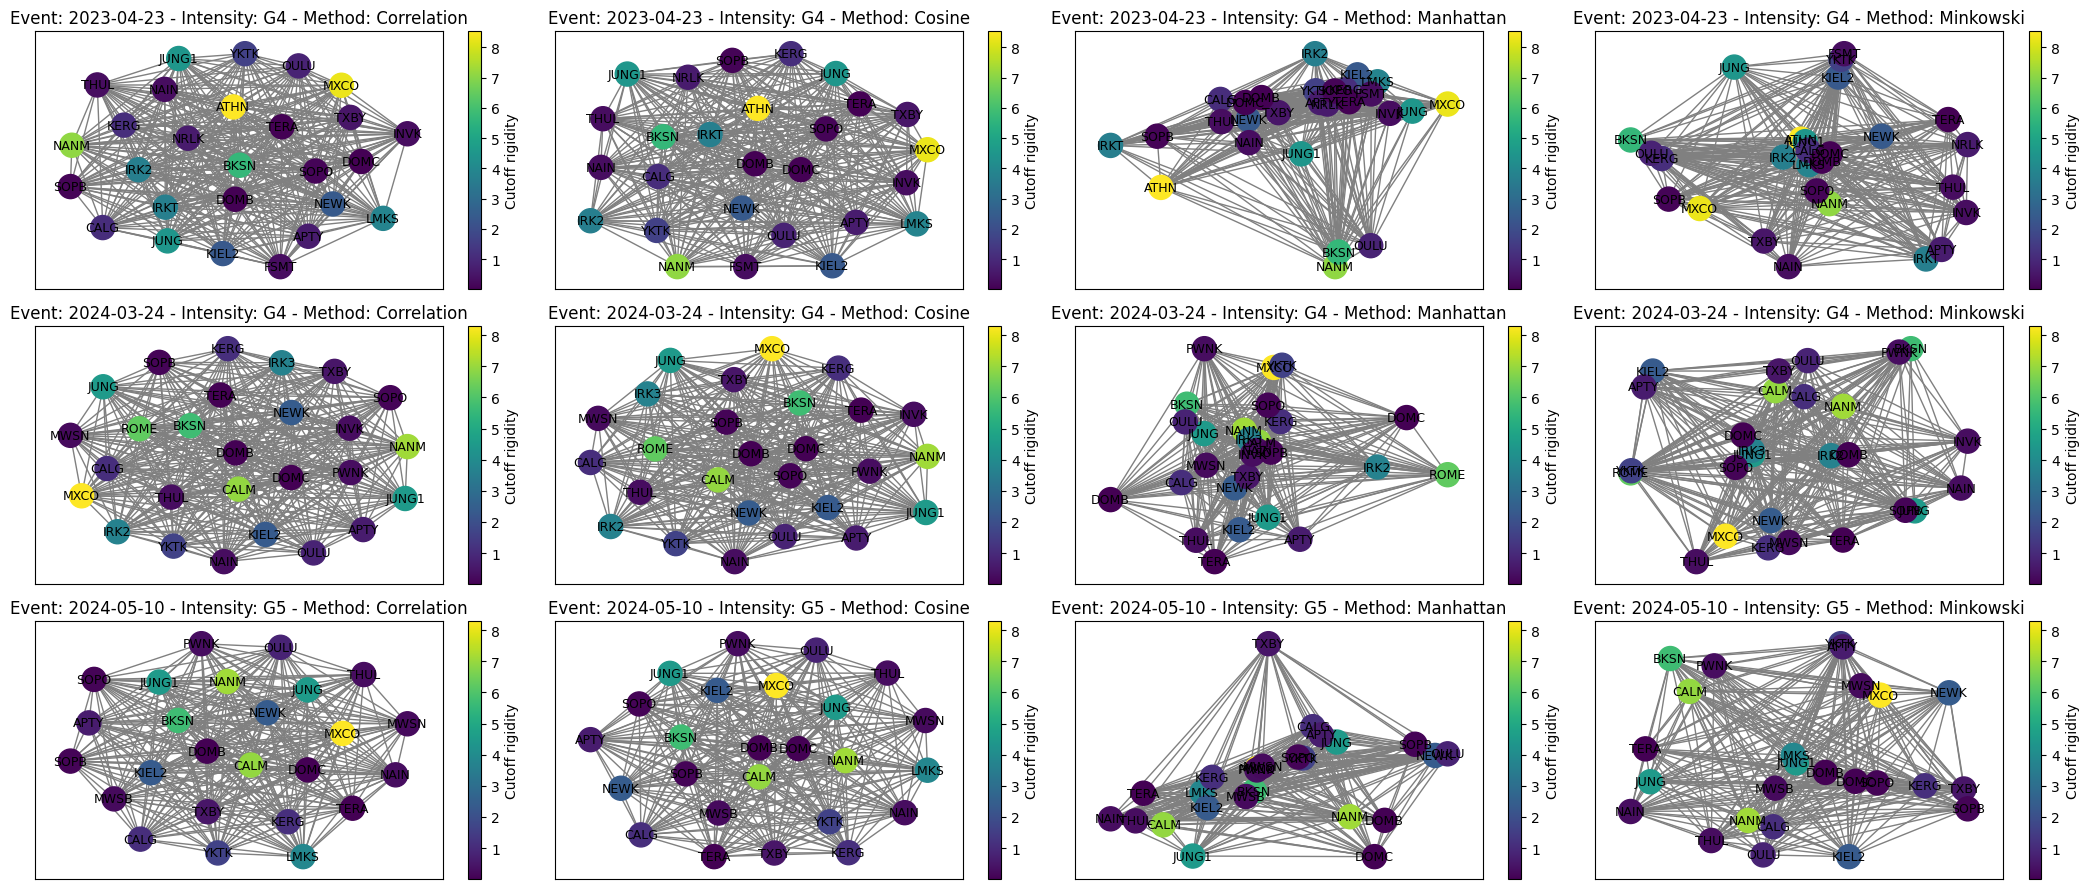

In [11]:
plot_grid = [3, 4]

cmap = plt.cm.viridis  # type: ignore

fig, axes = plt.subplots(*plot_grid, figsize=(21, 9))
axes = axes.flatten()
i = 0

for event_date, data in events.items():
    cutoff = data.get("cutoff_rigidity", {})
    for method, graph in data["graphs"].items():
        ax = axes[i]
        i += 1

        graph = data["graphs"][method]
        pos = nx.spring_layout(graph, weight="weight", seed=42)

        nodes = list(graph.nodes())
        vals = np.array([cutoff.get(n, np.nan) for n in nodes], dtype=float)

        # Another layout option
        # pos = nx.kamada_kawai_layout(graph, weight="weight")

        if np.all(np.isnan(vals)):
            nx.draw(
                graph,
                pos,
                ax=ax,
                with_labels=True,
                node_size=300,
                font_size=9,
                font_color="black",
                node_color="red",
                edge_color="gray",
            )
        else:
            vmin = np.nanmin(vals)
            vmax = np.nanmax(vals)
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # type: ignore

            nx.draw_networkx_nodes(
                graph,
                pos,
                nodelist=nodes,
                node_color=vals,
                cmap=cmap,
                node_size=300,
                ax=ax,
            )
            nx.draw_networkx_labels(graph, pos, font_size=9, ax=ax)
            nx.draw_networkx_edges(graph, pos, edge_color="gray", ax=ax)

            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Cutoff rigidity")

        ax.set_title(
            f"Event: {event_date} - Intensity: {data['intensity']} - Method: {method.name.title()}"
        )

fig.tight_layout()
plt.show()

In [12]:
graph.graph

{'metadata_event_date': '2024-05-10',
 'metadata_intensity': 'G5',
 'metadata_cutoff_rigidity': {'AATB': 5.9,
  'APTY': 0.65,
  'BKSN': 5.7,
  'CALG': 1.08,
  'CALM': 6.95,
  'DOMB': 0.01,
  'DOMC': 0.01,
  'DRBS': 3.18,
  'FSMT': 0.3,
  'INVK': 0.3,
  'IRK2': 3.64,
  'IRK3': 3.64,
  'JBGO': 0.3,
  'JUNG': 4.49,
  'JUNG1': 4.49,
  'KERG': 1.14,
  'KIEL2': 2.36,
  'LMKS': 3.84,
  'MWSB': 0.22,
  'MWSN': 0.22,
  'MXCO': 8.28,
  'NAIN': 0.3,
  'NANM': 7.1,
  'NEWK': 2.4,
  'OULU': 0.81,
  'PWNK': 0.3,
  'ROME': 6.27,
  'SOPB': 0.1,
  'SOPO': 0.1,
  'TERA': 0.01,
  'THUL': 0.3,
  'TXBY': 0.48,
  'YKTK': 1.65}}